In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [31]:
tesla_stocks = pd.read_csv('ibm2year.csv')

In [32]:

tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,1/10/2017,167.979996,168.089996,165.339996,165.520004,4118700
1,1/11/2017,166.050003,167.759995,165.600006,167.750000,3599500
2,1/12/2017,167.770004,168.009995,165.559998,167.949997,2927500
3,1/13/2017,167.970001,168.479996,166.880005,167.339996,2875400
4,1/17/2017,166.690002,168.179993,166.119995,167.889999,3302900


In [33]:
data_to_use = tesla_stocks['Close'].values

In [34]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 504


In [35]:
scaler = StandardScaler()

In [36]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

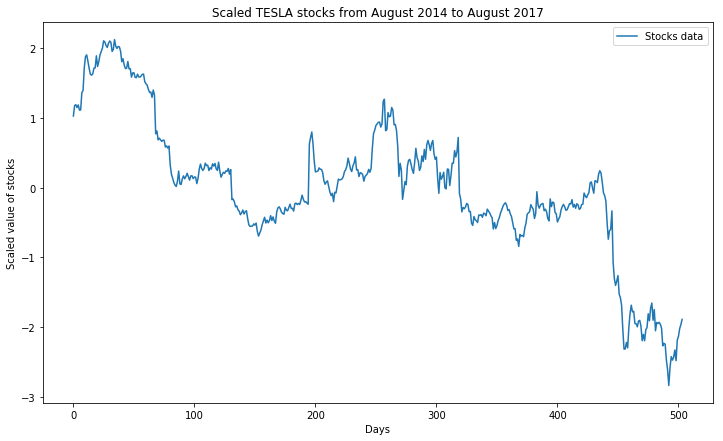

In [37]:

plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [38]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [39]:
X, y = window_data(scaled_dataset, 7)

In [40]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (497, 7, 1)
y_train size: (497, 1)
X_test size: (0,)
y_test size: (0,)


In [41]:
epochs = 200
batch_size = 7

In [42]:

def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [43]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [44]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [45]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [46]:
tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)


In [47]:
session =  tf.Session()

In [48]:
session.run(tf.global_variables_initializer())

In [49]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.10675284266471863
Epoch 30/200  Current loss: 0.013759135268628597
Epoch 60/200  Current loss: 0.010970229282975197
Epoch 90/200  Current loss: 0.010763393715023994
Epoch 120/200  Current loss: 0.010082683525979519
Epoch 150/200  Current loss: 0.011586157605051994
Epoch 180/200  Current loss: 0.010866769589483738


In [50]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [51]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [52]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [53]:

test_results = []
for i in range(497):
    if i >= 497:
        test_results.append(tests_new[i-497])
    else:
        test_results.append(None)

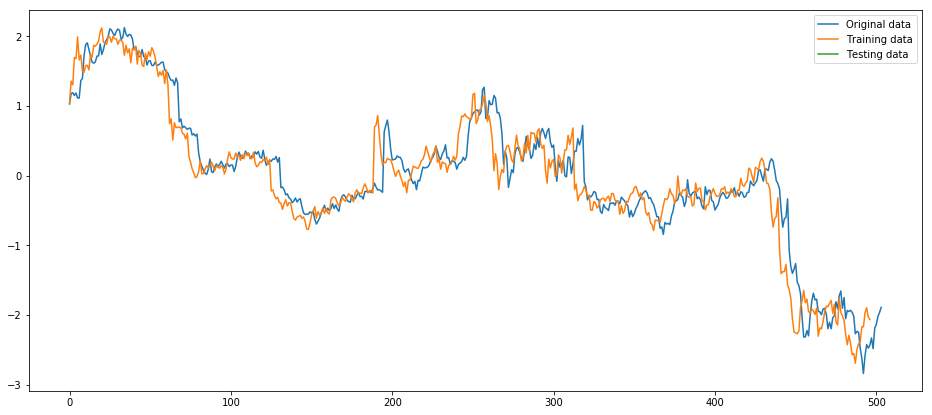

In [54]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [29]:
session.close()